# **SOW-MKI49-2019-SEM1-V: NeurIPS**
## Project: Neurosmash

### Features this notebook entails:
- DDQN
- Start training only when the buffer is full

### Imports

In [1]:
import numpy as np
import socket
from PIL import Image, ImageChops
import struct
import math
import time
import random
import matplotlib.pyplot as plt
import matplotlib
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
import torch.cuda

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Use", device, "for pytroch")

Use cuda for pytroch


### Settings

In [2]:
# These are the default environment arguments. They must be the same as the values that are set in the environment GUI.
ip         = "192.168.0.104" # Ip address that the TCP/IP interface listens to
port       = 13011       # Port number that the TCP/IP interface listens to
size       = 64         # Please check the Updates section above for more details
timescale  = 10           # Please check the Updates section above for more details

# This will be used as filename prefix for all files, such as weights, that are saved by this notebook.
# This is handy when copying and running the notebook multiple times at the same time.
prefix = "2DDQN_"

### Setup Neurosmash

In [3]:
class Neurosmash_Agent:
    def __init__(self):
        pass

    def step(self, end, reward, state):
        # return 0 # nothing
        # return 1 # left
        # return 2 # right
        return   2 # random

class Neurosmash_Environment:
    def __init__(self, ip = "127.0.0.1", port = 13000, size = 768, timescale = 1):
        self.client     = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.ip         = ip
        self.port       = port
        self.size       = size
        self.timescale  = timescale

        self.client.connect((ip, port))

    def reset(self):
        self._send(1, 0)
        return self._receive()

    def step(self, action):
        self._send(2, action)
        return self._receive()

    def state2image(self, state):
        return Image.fromarray(np.array(state, "uint8").reshape(self.size, self.size, 3))

    def _receive(self):
        # Kudos to Jan for the socket.MSG_WAITALL fix!
        data   = self.client.recv(2 + 3 * self.size ** 2, socket.MSG_WAITALL)
        end    = data[0]
        reward = data[1]
        state  = [data[i] for i in range(2, len(data))]

        return end, reward, state

    def _send(self, action, command):
        self.client.send(bytes([action, command]))

In [4]:
agent = Neurosmash_Agent() # This is an example agent.
                           # It has a step function, which gets reward/state as arguments and returns an action.
                           # Right now, it always outputs a random action (3) regardless of reward/state.
                           # The real agent should output one of the following three actions:
                           # none (0), left (1) and right (2)

environment = Neurosmash_Environment(ip=ip, port=port, size=size, timescale=timescale) # This is the main environment.
                                       # It has a reset function, which is used to reset the environment before episodes.
                                       # It also has a step function, which is used to which steps one time point
                                       # It gets an action (as defined above) as input and outputs the following:
                                       # end (true if the episode has ended, false otherwise)
                                       # reward (10 if won, 0 otherwise)
                                       # state (flattened size x size x 3 vector of pixel values)
                                       # The state can be converted into an image as follows:
                                       # image = np.array(state, "uint8").reshape(size, size, 3)
                                       # You can also use to Neurosmash.Environment.state2image(state) function which returns
                                       # the state as a PIL image

### Setup Model

In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
            
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
    

In [6]:
class NoisyLinear(nn.Module):
    """
    NoisyNet layer with factorized gaussian noise
    """
    
    '''
    def __init__(self, in_features, out_features, sigma_zero=0.4):
        super(NoisyFactorizedLinear, self).__init__(in_features, out_features)
        sigma_init = sigma_zero / math.sqrt(in_features)
        self.sigma_weight = nn.Parameter(torch.Tensor(out_features, in_features).fill_(sigma_init))
        self.register_buffer("epsilon_input", torch.zeros(1, in_features))
        self.register_buffer("epsilon_output", torch.zeros(out_features, 1))
        self.sigma_bias = nn.Parameter(torch.Tensor(out_features).fill_(sigma_init))
        

    def forward(self, input, bias):
        torch.randn(self.epsilon_input.size(), out=self.epsilon_input)
        torch.randn(self.epsilon_output.size(), out=self.epsilon_output)

        func = lambda x: torch.sign(x) * torch.sqrt(torch.abs(x))
        eps_in = func(self.epsilon_input)
        eps_out = func(self.epsilon_output)

        
        bias_noise = nn.Parameter(bias + self.sigma_bias * Variable(eps_out.t()))
        noise_v = Variable(torch.mul(eps_in, eps_out))
        return F.linear(input, self.weight + self.sigma_weight * noise_v, bias_noise)
    '''
    
    def __init__(self, inp, out, sigma_zero=0.5, bias=True):
        
        super(NoisyLinear, self).__init__()
        '''
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out))
        else:
            self.register_parameter('bias', None)
        '''
            
        self.func = lambda x: torch.sign(x) * torch.sqrt(torch.abs(x))
          
        ### weights
        self.mu_w = torch.empty(out, inp, dtype=torch.float32, device=device).uniform_(-1/np.sqrt(inp), 1/np.sqrt(inp))
        self.sigma_w = torch.empty(out, inp, dtype=torch.float32, device=device).fill_(sigma_zero / np.sqrt(inp))
        
        self.epsilon_input = torch.zeros(inp, dtype=torch.float32, device=device)
        self.epsilon_output = torch.zeros(out, dtype=torch.float32, device=device)
        
        
        ### bias
        self.mu_b = torch.empty(out, dtype=torch.float32, device=device).uniform_(-1/np.sqrt(inp), 1/np.sqrt(inp))
        self.sigma_b = torch.empty(out, dtype=torch.float32, device=device).fill_(sigma_zero / np.sqrt(inp))
        
        
    def forward(self, x):
        torch.randn(self.epsilon_input.size(), out=self.epsilon_input)
        torch.randn(self.epsilon_output.size(), out=self.epsilon_output)
        
        eps_w = self.func(self.epsilon_input)
        eps_b = self.func(self.epsilon_output)
        
        bias_param = torch.add(self.mu_b, torch.mul(self.sigma_b, eps_b))
                  
        return F.linear(x, torch.add(self.mu_w, torch.mul(self.sigma_w, eps_w)), bias_param)


In [7]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        
        convw = conv2d_size_out(conv2d_size_out(w, kernel_size=8, stride=4), kernel_size=4, stride=2)
        convh = conv2d_size_out(conv2d_size_out(h, kernel_size=8, stride=4), kernel_size=4, stride=2)
      
        
        linear_input_size = convw * convh * 32
        
        '''
        self.lin1 = nn.Linear(linear_input_size, 256)
        self.head = nn.Linear(256, outputs)
        '''
        
        self.lin1 = NoisyLinear(linear_input_size, 256)
        self.head = NoisyLinear(256, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.lin1(x.view(x.size(0), -1)))
        
        return self.head(x.view(x.size(0), -1))


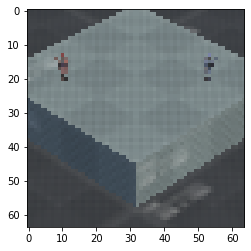

In [8]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 1
EPS_END = 0.01
EPS_DECAY = 5000
TARGET_UPDATE = 10

# Initialize environment, gather initial state
end, reward, state = environment.reset()
screen = environment.state2image(state)
plt.imshow(screen)
screen_shape = np.shape(screen)
n_actions = 3

# Initialize DQN network
policy_net = DQN(screen_shape[0], screen_shape[1], n_actions).to(device)
target_net = DQN(screen_shape[0], screen_shape[1], n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adagrad(policy_net.parameters())
memory = ReplayMemory(10000)
episode_durations = []
episode_rewards = []
episode_eps = []
steps_done = 0
winCounter = 0
current_eps = EPS_START
trainingStarted = -1

### Utilities

In [9]:
#TODO: make a direct state2input function
def image2input(screen):
    """ Converts an image gained from the environment (through environment.state2image) to ready-to-use input"""
    # Transpose to pytorch order of dimensions (cwh)
    screen = np.transpose(screen, axes=(2,0,1))
    # Translate to rgb float values
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    # Convert to tensor
    screen = torch.from_numpy(screen)
    # Add batch dimension, yeet to device
    screen = screen.unsqueeze(0).to(device)
    return screen

def select_action(state):
    global steps_done, current_eps
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    current_eps = eps_threshold
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


def plot_information():
    plt.figure(2)
    plt.clf()
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())
    
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    plt.title('Reward over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    #plt.plot(episode_durations, label="durations")
    plt.scatter(range(rewards_t.numpy().shape[0]), rewards_t.numpy(),
                alpha = 0.5, s = 7, label="reward")
    
    # Take 100 episode averages and plot them too
    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy(), label="reward mean", color="orange")
    if trainingStarted != -1:
        plt.axvline(x=trainingStarted, color="green", label="training started")
    plt.gca().grid(axis='y', linestyle='--')  
    plt.legend()
    plt.show()
    
    plt.title('Episode Durations')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(episode_durations, label="durations")
    if trainingStarted != -1:
        plt.axvline(x=trainingStarted, color="green", label="training started")
    plt.show()
    
    plt.title('EPS history')
    plt.xlabel('Episode')
    plt.ylabel('EPS')
    plt.plot(episode_eps, label="eps")
    if trainingStarted != -1:
        plt.axvline(x=trainingStarted, color="green", label="training started")
    plt.show()
    
    plt.pause(0.001)  # pause a bit so that plots are updated

### Training

In [10]:
def optimize_model():
    
    transitions = memory.sample(BATCH_SIZE)
    
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))
    
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    
    # double dqn party
    indexBestAction = policy_net(non_final_next_states).argmax(1).detach()
    next_state_values[non_final_mask] = target_net(non_final_next_states)[np.arange(indexBestAction.size()[0]), indexBestAction].detach()
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()


<Figure size 432x288 with 0 Axes>

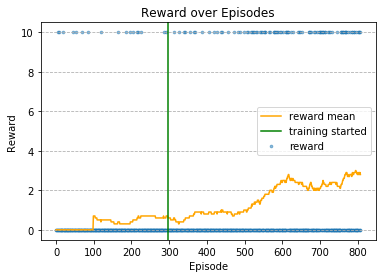

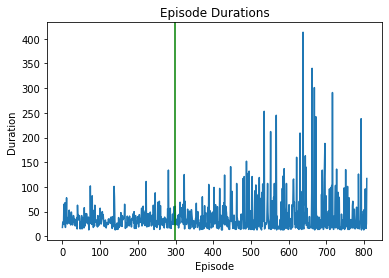

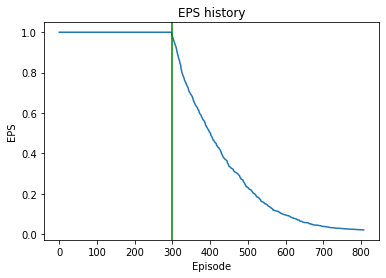

Episode 807 completed in 12.793972730636597 with reward 0
Number of wins: 112
Total training duration: 58.642298471927646 m
Total number of steps: 22357
Training started at: 298
Memeory Size: 10000


In [ ]:
num_episodes = 10000

trainingStartTime = time.time()
for i_episode in range(num_episodes):
    timer = time.time()
    
    # Initialize the environment and state
    end, reward, state = environment.reset()
    state = image2input(environment.state2image(state))
    last_state = state
    current_state = state
    state = current_state - last_state
    
    currentEpisodeRewards = []
    currentEpisodeHistory = []
    
    for t in count():
        # Select and perform an action
        # A random action is performed as long as the memory is not full
        if len(memory) < memory.capacity:
            action = torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)
        else:
            action = select_action(state)
        end, reward, state = environment.step(action.item())
        
        if reward == 10:
            winCounter += 1
        
        currentEpisodeRewards.append(reward)

        state = image2input(environment.state2image(state))
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_state = current_state
        current_state = state
        if not end:
            next_state = current_state - last_state
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)
        currentEpisodeHistory.append([state, action, next_state, reward])

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        if len(memory) >= memory.capacity:
            if trainingStarted == -1:
                trainingStarted = i_episode
            optimize_model()
        
        if end:
            episode_durations.append(t + 1)
            episode_rewards.append(np.sum(currentEpisodeRewards))
            episode_eps.append(current_eps)
            plot_information()
            break

    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    # save current weights and other goodies
    if (i_episode+1)%50 == 0:
        torch.save(policy_net.state_dict(), prefix + "policynet_" + str(i_episode+1) +".kek")
        torch.save(episode_rewards, prefix + "episode_rewards.kek")
        torch.save(episode_durations, prefix + "episode_durations.kek")
        torch.save(episode_eps, prefix + "episode_eps.kek")
        torch.save(trainingStarted, prefix + "trainingStarted.kek")
        
    print("Episode", i_episode, "completed in", time.time() - timer, "with reward", episode_rewards[-1])
    print("Number of wins:", winCounter)
    print("Total training duration:", (time.time() - trainingStartTime) / 60, "m")
    print("Total number of steps:", steps_done)
    print("Training started at:", trainingStarted)
    print("Memeory Size:", len(memory))
        
print('Complete')
# env.render()
# env.close()
plt.ioff()
plt.show()